In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, AutoModel
from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
import os
import ast
from torch.utils.data import Dataset, DataLoader

In [ ]:
# --- Define Paths
drive_path = '/content/drive/MyDrive/Embedding_Based_Recommendations_Project/Datasets/final_datasets/'
stratified_data_path = os.path.join(drive_path, 'multimodal_movies_stratified_prototype_dataset.parquet')
content_embeddings_output_path = os.path.join(drive_path, 'movie_content_embeddings.parquet')

if 'stratified_prototype_df' not in locals():
    print(f"Loading stratified prototype dataset from: {stratified_data_path}")
    if not os.path.exists(stratified_data_path):
        raise FileNotFoundError(f"Stratified dataset not found at {stratified_data_path}. Please run Phase 3.0 first and upload the file.")
    try:
        stratified_prototype_df = pd.read_parquet(stratified_data_path)
        print(f"Stratified prototype dataset loaded. Shape: {stratified_prototype_df.shape}")
    except Exception as e:
        raise Exception(f"Error loading stratified prototype dataset: {e}")
else:
    print("Stratified prototype dataset already in memory. Shape:", stratified_prototype_df.shape)


In [ ]:
# ---Initialize Pre-trained Models ---
print("\nInitializing pre-trained models (CLIP, Sentence-BERT)...")

# --- CLIP Model for Image and Core Text (Plot Description) ---
try:
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    print("CLIP model loaded successfully.")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    clip_model.to(device)
    print(f"CLIP model moved to: {device}")
except Exception as e:
    print(f"Error loading CLIP model: {e}. Please ensure transformers library is up-to-date and internet is accessible.")
    raise

# --- Sentence-BERT for Rich Text Features (Crew, Cast, Tagline) ---
try:
    sbert_model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
    sbert_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
    print("Sentence-BERT model loaded successfully.")
    sbert_model.to(device)
except Exception as e:
    print(f"Error loading Sentence-BERT model: {e}. Please ensure sentence-transformers is installed and internet is accessible.")
    raise

Loading stratified prototype dataset from: /content/drive/MyDrive/Embedding_Based_Recommendations_Project/Datasets/final_datasets/multimodal_movies_stratified_prototype_dataset.parquet


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Stratified prototype dataset loaded. Shape: (2000, 35)

Initializing pre-trained models (CLIP, Sentence-BERT)...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIP model loaded successfully.
CLIP model moved to: cuda


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Sentence-BERT model loaded successfully.


In [ ]:
movies_df.columns

Index(['tmdb_id', 'title', 'plot_description', 'genres', 'adult', 'tagline',
       'directors', 'writer', 'composer', 'cinematographer', 'editor',
       'productiondesigner', 'artdirector', 'main_actors',
       'crew_text_features', 'cast_text_features', 'original_language',
       'runtime', 'vote_average', 'vote_count', 'release_date', 'popularity',
       'budget', 'revenue', 'Poster_available', 'poster_byte', 'avg_rgb_color',
       'directors_parsed', 'writer_parsed', 'composer_parsed',
       'cinematographer_parsed', 'editor_parsed', 'productiondesigner_parsed',
       'artdirector_parsed', 'main_actors_parsed'],
      dtype='object')

# MODEL 1 :

**With `TripletMarginLoss` with genre as the anchor**

In [ ]:
# --- 1. Configuration and Paths ---
DRIVE_BASE_PATH = '/content/drive/MyDrive/Embedding_Based_Recommendations_Project/Datasets/final_datasets/'

INPUT_DATA_PATH = os.path.join(DRIVE_BASE_PATH, 'multimodal_movies_stratified_prototype_dataset.parquet')
EMBEDDINGS_OUTPUT_PATH = os.path.join(DRIVE_BASE_PATH, 'movie_content_embeddings.parquet')
FUSION_MODEL_OUTPUT_PATH = os.path.join(DRIVE_BASE_PATH, 'fusion_mlp_model.pth')

In [ ]:
# --- 2. Load Dataset ---
print(f"Loading dataset from: {INPUT_DATA_PATH}")
if not os.path.exists(INPUT_DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {INPUT_DATA_PATH}. Please ensure the file exists.")

try:
    movies_df = pd.read_parquet(INPUT_DATA_PATH)
    print(f"Dataset loaded successfully. Shape: {movies_df.shape}")
except Exception as e:
    raise Exception(f"Error loading dataset: {e}")


import ast

def get_primary_genre(genre_list_str):
    """
    Safely extracts the NAME of the first genre from a string representation of a list of dicts.
    """
    try:
        genres = ast.literal_eval(str(genre_list_str))
        # Check if it's a list, not empty, the first item is a dict, and has the 'name' key
        if isinstance(genres, list) and genres and isinstance(genres[0], dict) and 'name' in genres[0]:
            return genres[0]['name'] # <-- THIS IS THE FIX: Return the name string
    except (ValueError, SyntaxError):
        pass
    return 'Unknown' # Default value

# Apply the function to create the new column
movies_df['primary_genre'] = movies_df['genres'].apply(get_primary_genre)

# Display the first few entries of the new column to verify
print("Created 'primary_genre' column. Here's a sample:")
print(movies_df[['title', 'genres', 'primary_genre']].head())

In [ ]:
# --- 3. Initialize Pre-trained Models ---
print("\nInitializing pre-trained models...")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# CLIP Model for Image and Plot Description
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
for param in clip_model.parameters():
    param.requires_grad = False
print("CLIP model loaded and frozen.")

# Sentence-BERT for other text features
sbert_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
sbert_model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2').to(device)
for param in sbert_model.parameters():
    param.requires_grad = False
print("Sentence-BERT model loaded and frozen.")

In [ ]:
# --- 4. Define the Content Embedding Model with Fusion MLP ---
class ContentEmbeddingModel(nn.Module):
    def __init__(self, clip_model, sbert_model, final_embedding_dim=512):
        super().__init__()
        self.clip_model = clip_model
        self.sbert_model = sbert_model
        self.device = next(clip_model.parameters()).device

        # Define dimensions
        clip_output_dim = self.clip_model.config.projection_dim
        sbert_output_dim = self.sbert_model.config.hidden_size
        avg_rgb_dim = 3
        # plot_desc(clip), poster(clip), crew(sbert), cast(sbert), tagline(sbert), rgb
        total_input_dim = clip_output_dim * 2 + sbert_output_dim * 3 + avg_rgb_dim

        # The FUSION MLP that we will train
        self.fusion_mlp = nn.Sequential(
            nn.Linear(total_input_dim, final_embedding_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(final_embedding_dim * 2, final_embedding_dim)
        ).to(self.device)

    def _mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, plot_description, poster_byte, crew_text, cast_text, tagline, avg_rgb_color):
        # 1. Process Plot Description (CLIP)
        clip_text_inputs = clip_processor(text=plot_description, return_tensors="pt", padding=True, truncation=True).to(self.device)
        with torch.no_grad():
            clip_text_features = self.clip_model.get_text_features(**clip_text_inputs)

        # 2. Process Poster Image (CLIP)
        images = []
        for img_bytes in poster_byte:
            try:
                img = Image.open(BytesIO(img_bytes)).convert("RGB")
            except:
                img = Image.new('RGB', (224, 224), color='black') # Placeholder for corrupt images
            images.append(img)
        clip_image_inputs = clip_processor(images=images, return_tensors="pt").to(self.device)
        with torch.no_grad():
            clip_image_features = self.clip_model.get_image_features(**clip_image_inputs)

        # 3. Process Other Text Features (Sentence-BERT)
        sbert_features_list = []
        for text_batch in [crew_text, cast_text, tagline]:
            encoded_input = sbert_tokenizer(text_batch, padding=True, truncation=True, return_tensors='pt').to(self.device)
            with torch.no_grad():
                model_output = self.sbert_model(**encoded_input)
            sentence_embeddings = self._mean_pooling(model_output, encoded_input['attention_mask'])
            sbert_features_list.append(sentence_embeddings)
        sbert_crew_features, sbert_cast_features, sbert_tagline_features = sbert_features_list

        # 4. Process Avg RGB Color
        avg_rgb_tensor = torch.tensor(avg_rgb_color, dtype=torch.float32, device=self.device)

        # 5. Concatenate all features
        combined_features = torch.cat([
            clip_text_features,
            clip_image_features,
            sbert_crew_features,
            sbert_cast_features,
            sbert_tagline_features,
            avg_rgb_tensor
        ], dim=1)

        # 6. Final Fusion through MLP
        return self.fusion_mlp(combined_features)


In [ ]:
# --- 5. Define Triplet Dataset for Training the Fusion MLP ---
class TripletDataset(Dataset):
    def __init__(self, df, movie_id_map):
        self.df = df
        self.movie_id_map = movie_id_map
        self.samples = self._prepare_training_samples()
        if not self.samples:
            print("WARNING: No training triplets were created. Check 'primary_genre' column and data variety.")
        else:
             print(f"Prepared {len(self.samples)} triplets for training.")

    def _get_movie_data(self, movie_id):
        data = self.movie_id_map[movie_id]
        # Robustly handle missing text and parse RGB color
        plot = str(data.get('plot_description', ''))
        poster = data.get('poster_byte')
        crew = str(data.get('crew_text_features', ''))
        cast = str(data.get('cast_text_features', ''))
        tagline = str(data.get('tagline', ''))
        rgb_raw = data.get('avg_rgb_color', '[0.0, 0.0, 0.0]')
        try:
            if isinstance(rgb_raw, str):
                rgb = ast.literal_eval(rgb_raw)
            else: # is list or numpy array
                rgb = list(rgb_raw)
        except:
            rgb = [0.0, 0.0, 0.0]
        return plot, poster, crew, cast, tagline, rgb

    def _prepare_training_samples(self):
        samples = []
        if 'primary_genre' not in self.df.columns:
            return samples

        genre_to_movies = self.df.groupby('primary_genre')['tmdb_id'].apply(list).to_dict()
        valid_genres = {g: ids for g, ids in genre_to_movies.items() if len(ids) >= 2}
        all_movie_ids = list(self.df['tmdb_id'].unique())

        for anchor_movie in tqdm(self.df.itertuples(), total=len(self.df), desc="Preparing Triplets"):
            anchor_id = anchor_movie.tmdb_id
            anchor_genre = getattr(anchor_movie, 'primary_genre', 'Unknown')
            if anchor_genre not in valid_genres:
                continue

            # Find Positive
            pos_candidates = [mid for mid in valid_genres[anchor_genre] if mid != anchor_id]
            if not pos_candidates: continue
            positive_id = np.random.choice(pos_candidates)

            # Find Negative
            neg_candidates = [mid for mid in all_movie_ids if mid not in valid_genres[anchor_genre]]
            if not neg_candidates: continue
            negative_id = np.random.choice(neg_candidates)

            samples.append({'anchor_id': anchor_id, 'positive_id': positive_id, 'negative_id': negative_id})
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        anchor_data = self._get_movie_data(sample['anchor_id'])
        positive_data = self._get_movie_data(sample['positive_id'])
        negative_data = self._get_movie_data(sample['negative_id'])
        return anchor_data, positive_data, negative_data

def custom_collate_fn(batch):
    # This function transposes the batch data for easier input into the model
    # from list of (anchor, positive, negative) tuples to (anchors, positives, negatives)
    anchors, positives, negatives = zip(*batch)

    # Each of these is now a tuple of (plot, poster, crew, cast, tagline, rgb)
    anchor_data = list(zip(*anchors))
    positive_data = list(zip(*positives))
    negative_data = list(zip(*negatives))

    return anchor_data, positive_data, negative_data

In [ ]:
# --- 6. De-duplicate Data and Prepare for Training ---
print("\nPreparing data for training...")
print(f"Original DataFrame shape: {movies_df.shape}")
num_duplicates = movies_df.duplicated(subset=['tmdb_id']).sum()

if num_duplicates > 0:
    print(f"Found and removed {num_duplicates} duplicate entries based on 'tmdb_id'.")
    movies_df_cleaned = movies_df.drop_duplicates(subset=['tmdb_id'], keep='first').copy()
else:
    print("No duplicate tmdb_ids found.")
    movies_df_cleaned = movies_df.copy()

print(f"Cleaned DataFrame shape: {movies_df_cleaned.shape}")

# Create the mapping from the CLEANED DataFrame
movie_id_to_data = movies_df_cleaned.set_index('tmdb_id').to_dict('index')
print("TMDB ID to data mapping created.")

# Instantiate model and optimizer
content_model = ContentEmbeddingModel(clip_model, sbert_model, final_embedding_dim=FINAL_EMBEDDING_DIM)
optimizer = torch.optim.Adam(content_model.fusion_mlp.parameters(), lr=LEARNING_RATE)
loss_function = nn.TripletMarginLoss(margin=TRIPLET_MARGIN, p=2.0)

# Create Dataset and DataLoader
triplet_dataset = TripletDataset(movies_df_cleaned, movie_id_to_data)


# Training Hyperparameters
BATCH_SIZE = 32
FINAL_EMBEDDING_DIM = 512
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
TRIPLET_MARGIN = 1.0


if len(triplet_dataset) > 0:
    triplet_dataloader = DataLoader(triplet_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn, num_workers=2, drop_last=True)

    # --- 7. Train the Fusion MLP ---
    print(f"\nTraining Fusion MLP for {NUM_EPOCHS} epochs...")
    content_model.fusion_mlp.train()

    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0
        for (anchor_inputs, positive_inputs, negative_inputs) in tqdm(triplet_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
            optimizer.zero_grad()

            anchor_emb = content_model(*anchor_inputs)
            positive_emb = content_model(*positive_inputs)
            negative_emb = content_model(*negative_inputs)

            loss = loss_function(anchor_emb, positive_emb, negative_emb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(triplet_dataloader)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Average Triplet Loss: {avg_epoch_loss:.4f}")

    # Save the trained model weights
    torch.save(content_model.fusion_mlp.state_dict(), FUSION_MODEL_OUTPUT_PATH)
    print(f"Trained Fusion MLP weights saved to {FUSION_MODEL_OUTPUT_PATH}")
else:
    print("Skipping training as no triplets were generated.")

In [ ]:
# --- 8. Generate and Save Final Embeddings ---
print("\nGenerating final content embeddings for all movies...")
content_model.eval()

# Use the full (but cleaned) dataframe to generate embeddings for every movie
all_embeddings = []
with torch.no_grad():
    for i in tqdm(range(0, len(movies_df_cleaned), BATCH_SIZE), desc="Generating Final Embeddings"):
        batch_df = movies_df_cleaned.iloc[i:i+BATCH_SIZE]

        plots = batch_df['plot_description'].fillna('').tolist()
        posters = batch_df['poster_byte'].tolist()
        crews = batch_df['crew_text_features'].fillna('').tolist()
        casts = batch_df['cast_text_features'].fillna('').tolist()
        taglines = batch_df['tagline'].fillna('').tolist()

        rgbs = []
        for item in batch_df['avg_rgb_color']:
            try:
                if isinstance(item, str): rgbs.append(ast.literal_eval(item))
                else: rgbs.append(list(item))
            except: rgbs.append([0.0, 0.0, 0.0])

        batch_embeddings = content_model(plots, posters, crews, casts, taglines, rgbs)
        all_embeddings.append(batch_embeddings.cpu().numpy())

final_embeddings = np.vstack(all_embeddings)
movies_df_cleaned['content_embedding'] = list(final_embeddings)
print(f"Generated embeddings for {final_embeddings.shape[0]} movies.")

# Save the final DataFrame with embeddings
movies_df_cleaned.to_parquet(EMBEDDINGS_OUTPUT_PATH, index=False)
print(f"Content embeddings saved successfully to: {EMBEDDINGS_OUTPUT_PATH}")
print("\n✅ Content embedding generation complete.")

Loading dataset from: /content/drive/MyDrive/Embedding_Based_Recommendations_Project/Datasets/final_datasets/multimodal_movies_stratified_prototype_dataset.parquet
Dataset loaded successfully. Shape: (2000, 35)
Created 'primary_genre' column. Here's a sample:
                                    title  \
0  Doctor Who: The Husbands of River Song   
1                                McConkey   
2                               Nine Dead   
3         The Iceman and the Psychiatrist   
4                                Whiteout   

                                              genres primary_genre  
0  [{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...         Drama  
1  [{'id': 99, 'name': 'Documentary'}, {'id': 12,...   Documentary  
2  [{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...         Crime  
3  [{'id': 80, 'name': 'Crime'}, {'id': 99, 'name...         Crime  
4  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...        Action  

Initializing pre-trained models...
Using device: cuda


Preparing Triplets:   0%|          | 0/1983 [00:00<?, ?it/s]

Prepared 1983 triplets for training.

Training Fusion MLP for 10 epochs...


Epoch 1/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 1/10, Average Triplet Loss: 2.6735


Epoch 2/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 2/10, Average Triplet Loss: 1.9686


Epoch 3/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 3/10, Average Triplet Loss: 1.4368


Epoch 4/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 4/10, Average Triplet Loss: 1.0535


Epoch 5/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 5/10, Average Triplet Loss: 0.8758


Epoch 6/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 6/10, Average Triplet Loss: 0.7438


Epoch 7/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 7/10, Average Triplet Loss: 0.6365


Epoch 8/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 8/10, Average Triplet Loss: 0.5449


Epoch 9/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 9/10, Average Triplet Loss: 0.4702


Epoch 10/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 10/10, Average Triplet Loss: 0.4038
Trained Fusion MLP weights saved to /content/drive/MyDrive/Embedding_Based_Recommendations_Project/Datasets/final_datasets/fusion_mlp_model.pth

Generating final content embeddings for all movies...


Generating Final Embeddings:   0%|          | 0/62 [00:00<?, ?it/s]

Generated embeddings for 1983 movies.
Content embeddings saved successfully to: /content/drive/MyDrive/Embedding_Based_Recommendations_Project/Datasets/final_datasets/movie_content_embeddings.parquet

✅ Content embedding generation complete.


*TESTING THE MODEL 1 ON EMBEDDING SANITY AND CLUSTERING QUALITY*

✅ 1. Loading Embeddings...
Embeddings loaded successfully. Shape: (1983, 512)

✅ 2. Performing Sanity Checks...
✔️ No NaN or infinity values found.
✔️ Stats: Mean=0.0026, Std=0.2181, Min=-1.1495, Max=1.3648

✅ 3. Analyzing Nearest Neighbors...

--- Finding movies similar to: 'The Dark Knight' (Genre: Drama) ---
  - Title: Fire Down Below                          | Genre: Action          | Similarity: 0.9553
  - Title: Chain Reaction                           | Genre: Horror          | Similarity: 0.9475
  - Title: Tales from the Crypt: Demon Knight       | Genre: Horror          | Similarity: 0.9474
  - Title: The Midnight Man                         | Genre: Crime           | Similarity: 0.9471
  - Title: The Prodigy                              | Genre: Action          | Similarity: 0.9467
  - Title: Alien: Covenant                          | Genre: Horror          | Similarity: 0.9439
  - Title: Thorne: Sleepyhead                       | Genre: Crime           | Similarity: 0.9430
 

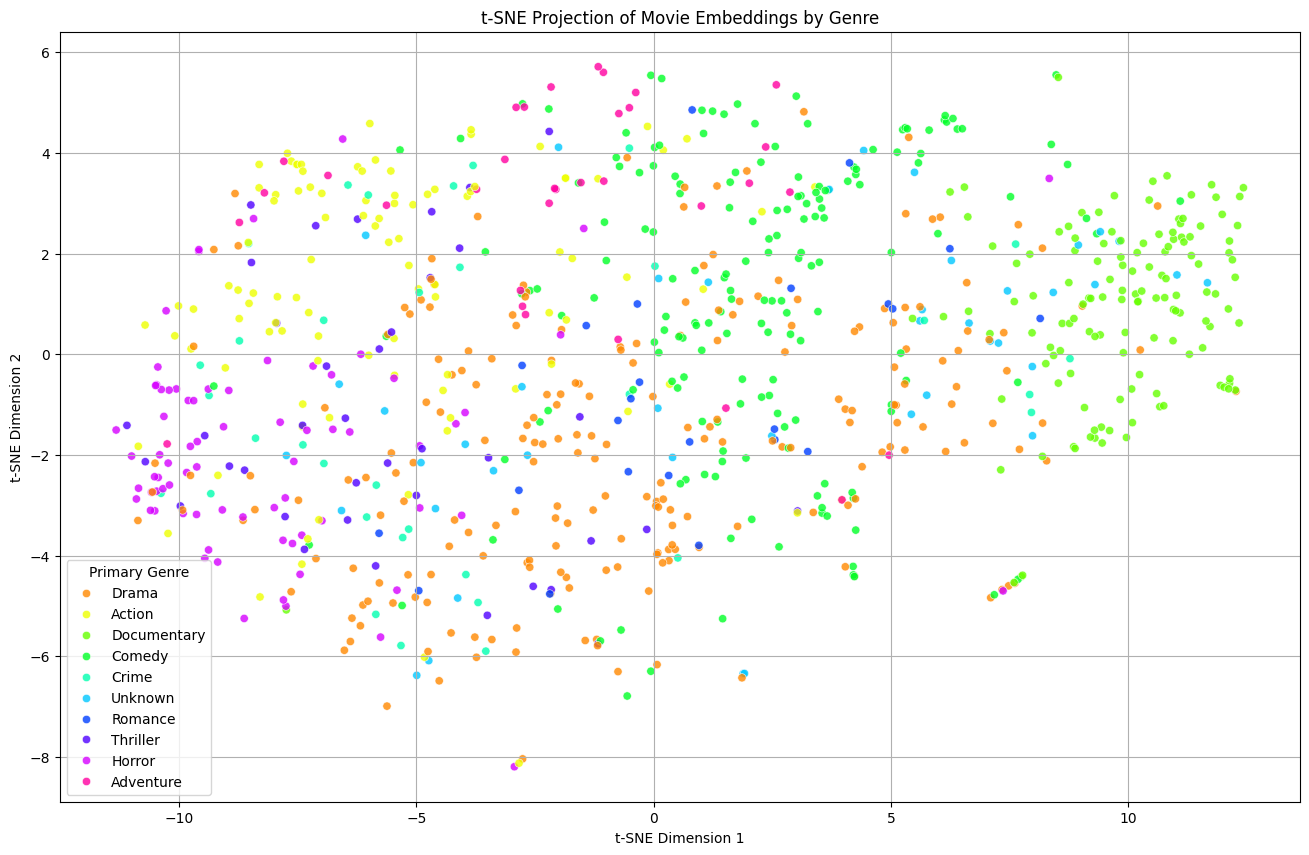


--- How to Interpret the t-SNE Plot ---
Look for distinct color clusters. If dots of the same color (genre) are grouped together,
it means your embeddings have successfully learned the semantic relationship between movies based on their genre.


In [ ]:
# --- 1. Setup and Load Data ---
print("✅ 1. Loading Embeddings...")

# --- IMPORTANT: Update this path to your file ---
EMBEDDINGS_PATH = '/content/drive/MyDrive/Embedding_Based_Recommendations_Project/Datasets/final_datasets/movie_content_embeddings.parquet'

try:
    df = pd.read_parquet(EMBEDDINGS_PATH)
except FileNotFoundError:
    raise FileNotFoundError(f"ERROR: File not found at {EMBEDDINGS_PATH}. Please verify the path.")

embeddings = np.array(df['content_embedding'].tolist())
print(f"Embeddings loaded successfully. Shape: {embeddings.shape}")


# --- 2. Perform Sanity Checks ---
print("\n✅ 2. Performing Sanity Checks...")

# Check for NaN or infinity values
if np.isnan(embeddings).any() or np.isinf(embeddings).any():
    print("❌ WARNING: Embeddings contain NaN or infinity values! This may indicate a problem in training.")
else:
    print("✔️ No NaN or infinity values found.")

# Check basic stats
print(f"✔️ Stats: Mean={np.mean(embeddings):.4f}, Std={np.std(embeddings):.4f}, Min={np.min(embeddings):.4f}, Max={np.max(embeddings):.4f}")


# --- 3. Nearest Neighbors Analysis ---
print("\n✅ 3. Analyzing Nearest Neighbors...")

def find_similar_movies(movie_title: str, top_n: int = 10):
    """
    Finds and prints the most similar movies to a given title based on cosine similarity.
    """
    if movie_title not in df['title'].values:
        print(f"❌ ERROR: Movie '{movie_title}' not found in the dataset.")
        return

    # Find the index and embedding of the anchor movie
    anchor_idx = df[df['title'] == movie_title].index[0]
    anchor_embedding = embeddings[anchor_idx].reshape(1, -1)
    anchor_genre = df.loc[anchor_idx, 'primary_genre']

    # Calculate cosine similarity between the anchor and all other movies
    sim_scores = cosine_similarity(anchor_embedding, embeddings)[0]

    # Get the indices of the most similar movies
    # We sort and take top_n+1 because the most similar movie will be itself
    similar_indices = np.argsort(sim_scores)[::-1][1:top_n+1]

    print(f"\n--- Finding movies similar to: '{movie_title}' (Genre: {anchor_genre}) ---")
    for idx in similar_indices:
        title = df.loc[idx, 'title']
        genre = df.loc[idx, 'primary_genre']
        score = sim_scores[idx]
        print(f"  - Title: {title:<40} | Genre: {genre:<15} | Similarity: {score:.4f}")

# --- Run some examples ---
# Pick movies from your dataset to test
find_similar_movies("The Dark Knight")
#find_similar_movies("Toy Story")
#find_similar_movies("The Conjuring")

# --- 4. 2D Visualization with t-SNE ---
print("\n✅ 4. Visualizing Embedding Space with t-SNE...")


sample_size = min(1000, len(df))
print(f"Running t-SNE on a sample of {sample_size} movies. This may take a minute...")

# Create a random sample of indices
sample_indices = np.random.choice(df.index, sample_size, replace=False)

# Get the corresponding embeddings and genres for the sample
sample_embeddings = embeddings[sample_indices, :]
sample_genres = df.loc[sample_indices, 'primary_genre']

# Perform t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(sample_embeddings)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame({
    'tsne-2d-one': tsne_results[:,0],
    'tsne-2d-two': tsne_results[:,1],
    'genre': sample_genres
})

# Get the top N genres for cleaner plotting
top_genres = tsne_df['genre'].value_counts().nlargest(10).index

# Filter the DataFrame to only include top genres
tsne_df_filtered = tsne_df[tsne_df['genre'].isin(top_genres)]

# Plot the results
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="genre",
    palette=sns.color_palette("hsv", 10),
    data=tsne_df_filtered,
    legend="full",
    alpha=0.8
)
plt.title('t-SNE Projection of Movie Embeddings by Genre')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Primary Genre')
plt.grid(True)
plt.show()

print("\n--- How to Interpret the t-SNE Plot ---")
print("Look for distinct color clusters. If dots of the same color (genre) are grouped together,")
print("it means your embeddings have successfully learned the semantic relationship between movies based on their genre.")

In [ ]:
df.columns

Index(['tmdb_id', 'title', 'plot_description', 'genres', 'adult', 'tagline',
       'directors', 'writer', 'composer', 'cinematographer', 'editor',
       'productiondesigner', 'artdirector', 'main_actors',
       'crew_text_features', 'cast_text_features', 'original_language',
       'runtime', 'vote_average', 'vote_count', 'release_date', 'popularity',
       'budget', 'revenue', 'Poster_available', 'poster_byte', 'avg_rgb_color',
       'directors_parsed', 'writer_parsed', 'composer_parsed',
       'cinematographer_parsed', 'editor_parsed', 'productiondesigner_parsed',
       'artdirector_parsed', 'main_actors_parsed', 'primary_genre',
       'content_embedding'],
      dtype='object')

# MODEL 2:
**with `TripletMarginLoss` loss with 3 different anchors (genre, directors and actors) and loss is combined and then .backward() is called**

In [ ]:
# --- Section: Multi-Task Content Embedding Generation ---

# --- 1. Configuration and Paths ---
DRIVE_BASE_PATH = '/content/drive/MyDrive/Embedding_Based_Recommendations_Project/Datasets/final_datasets/'
INPUT_DATA_PATH = os.path.join(DRIVE_BASE_PATH, 'multimodal_movies_stratified_prototype_dataset.parquet')
EMBEDDINGS_OUTPUT_PATH = os.path.join(DRIVE_BASE_PATH, 'movie_content_embeddings_multitask.parquet')
FUSION_MODEL_OUTPUT_PATH = os.path.join(DRIVE_BASE_PATH, 'fusion_mlp_model_multitask.pth')


In [ ]:
# --- 2. Load and Prepare Data ---
print("✅ 1. Loading and Preparing Data...")
df = pd.read_parquet(INPUT_DATA_PATH)

def get_better_primary_genre(genre_list_str):
    priority_genres = ['Action', 'Comedy', 'Horror', 'Science Fiction', 'Thriller', 'Animation', 'Documentary', 'Romance', 'Crime']
    try:
        genres = ast.literal_eval(str(genre_list_str))
        if not isinstance(genres, list): return 'Unknown'
        genre_names = {g['name'] for g in genres if isinstance(g, dict) and 'name' in g}
        for p_genre in priority_genres:
            if p_genre in genre_names:
                return p_genre
        if genre_names:
            return list(genre_names)[0]
    except:
        pass
    return 'Unknown'

df['primary_genre'] = df['genres'].apply(get_better_primary_genre)
df_cleaned = df.drop_duplicates(subset=['tmdb_id'], keep='first').copy()
print(f"Data prepared. Shape: {df_cleaned.shape}")

In [ ]:
# --- 3. Initialize Models (Same as before) ---
print("\n✅ 2. Initializing Models...")
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
sbert_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
sbert_model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2').to(device)
for param in list(clip_model.parameters()) + list(sbert_model.parameters()):
    param.requires_grad = False
print("Models loaded and frozen.")

In [ ]:
# --- 4. Content Embedding Model (Same as before) ---
class ContentEmbeddingModel(nn.Module):
    # This class is identical to your previous version. Just added again for readibility
    def __init__(self, clip_model, sbert_model, final_embedding_dim=512):
        super().__init__()
        self.clip_model = clip_model
        self.sbert_model = sbert_model
        self.device = next(clip_model.parameters()).device
        clip_output_dim = self.clip_model.config.projection_dim
        sbert_output_dim = self.sbert_model.config.hidden_size
        total_input_dim = clip_output_dim * 2 + sbert_output_dim * 3 + 3
        self.fusion_mlp = nn.Sequential(
            nn.Linear(total_input_dim, final_embedding_dim * 2), nn.ReLU(),
            nn.Dropout(0.3), nn.Linear(final_embedding_dim * 2, final_embedding_dim)
        ).to(self.device)

    def _mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, plot_description, poster_byte, crew_text, cast_text, tagline, avg_rgb_color):
        clip_text_inputs = clip_processor(text=plot_description, return_tensors="pt", padding=True, truncation=True).to(self.device)
        with torch.no_grad(): clip_text_features = self.clip_model.get_text_features(**clip_text_inputs)
        images = [Image.open(BytesIO(b)).convert("RGB") if b else Image.new('RGB', (224, 224)) for b in poster_byte]
        clip_image_inputs = clip_processor(images=images, return_tensors="pt").to(self.device)
        with torch.no_grad(): clip_image_features = self.clip_model.get_image_features(**clip_image_inputs)
        sbert_features = []
        for text_batch in [crew_text, cast_text, tagline]:
            encoded_input = sbert_tokenizer(text_batch, padding=True, truncation=True, return_tensors='pt').to(self.device)
            with torch.no_grad(): model_output = self.sbert_model(**encoded_input)
            sbert_features.append(self._mean_pooling(model_output, encoded_input['attention_mask']))
        avg_rgb_tensor = torch.tensor(avg_rgb_color, dtype=torch.float32, device=self.device)
        combined = torch.cat([clip_text_features, clip_image_features, *sbert_features, avg_rgb_tensor], dim=1)
        return self.fusion_mlp(combined)


In [ ]:
# --- 5. New Multi-Task Dataset and Collate Function ---
class MultiTaskTripletDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.movie_id_map = df.set_index('tmdb_id').to_dict('index')
        self.all_movie_ids = set(df['tmdb_id'].unique())
        self.genre_map = self._create_map('primary_genre')
        self.director_map = self._create_map('directors', is_list=True)
        self.actor_map = self._create_map('main_actors', is_list=True)
        self.samples = self._prepare_samples()
        print(f"Prepared {len(self.samples)} sample sets.")

    def _create_map(self, col, is_list=False):
        mapping = {}
        for _, row in self.df.iterrows():
            keys = row[col]
            if is_list and isinstance(keys, list):
                for key in keys:
                    if key not in mapping: mapping[key] = set()
                    mapping[key].add(row['tmdb_id'])
            elif not is_list:
                if keys not in mapping: mapping[keys] = set()
                mapping[keys].add(row['tmdb_id'])
        return {k: v for k, v in mapping.items() if len(v) >= 2}

    def _get_pair(self, anchor_id, key, mapping):
        pos_candidates = mapping.get(key, set()) - {anchor_id}
        if not pos_candidates: return None, None
        pos_id = np.random.choice(list(pos_candidates))
        neg_candidates = self.all_movie_ids - mapping.get(key, set())
        if not neg_candidates: return None, None
        neg_id = np.random.choice(list(neg_candidates))
        return pos_id, neg_id

    def _prepare_samples(self):
        samples = []
        for movie in tqdm(self.df.itertuples(), total=len(self.df), desc="Preparing Multi-Task Triplets"):
            s = {'anchor_id': movie.tmdb_id}
            pos, neg = self._get_pair(movie.tmdb_id, movie.primary_genre, self.genre_map)
            if pos: s['genre_pos'], s['genre_neg'] = pos, neg
            if movie.directors:
                pos, neg = self._get_pair(movie.tmdb_id, movie.directors[0], self.director_map)
                if pos: s['director_pos'], s['director_neg'] = pos, neg
            if movie.main_actors:
                pos, neg = self._get_pair(movie.tmdb_id, movie.main_actors[0], self.actor_map)
                if pos: s['actor_pos'], s['actor_neg'] = pos, neg
            if len(s) > 1: samples.append(s)
        return samples


    def _get_data(self, movie_id):
        d = self.movie_id_map[movie_id]

        # --- Robust RGB Parsing ---
        rgb_val = d.get('avg_rgb_color')
        final_rgb = [0.0, 0.0, 0.0]  # A safe default value

        if isinstance(rgb_val, str):
            try:
                # Safely evaluate string back to a list
                parsed = ast.literal_eval(rgb_val)
                if isinstance(parsed, list) and len(parsed) == 3:
                    final_rgb = [float(x) for x in parsed]
            except:
                pass  # Keep the default if string is malformed
        elif isinstance(rgb_val, (list, tuple, np.ndarray)) and len(rgb_val) == 3:
            try:
                # Handle cases where it's already a list, tuple, or numpy array
                final_rgb = [float(x) for x in rgb_val]
            except:
                pass  # Keep the default if list contains non-numeric data

        # Return all data, with a guaranteed valid list for the RGB value
        return (
            str(d.get('plot_description', '')),
            d.get('poster_byte'),
            str(d.get('crew_text_features', '')),
            str(d.get('cast_text_features', '')),
            str(d.get('tagline', '')),
            final_rgb
        )

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        anchor = self._get_data(s['anchor_id'])
        genre_triplet = (self._get_data(s['genre_pos']), self._get_data(s['genre_neg'])) if 'genre_pos' in s else None
        director_triplet = (self._get_data(s['director_pos']), self._get_data(s['director_neg'])) if 'director_pos' in s else None
        actor_triplet = (self._get_data(s['actor_pos']), self._get_data(s['actor_neg'])) if 'actor_pos' in s else None
        return anchor, genre_triplet, director_triplet, actor_triplet

def custom_multi_task_collate_fn(batch):
    """Processes a batch, filtering Nones and grouping by task."""
    anchor_in, genre_in, director_in, actor_in = zip(*batch)

    tasks = {}
    # For each task, find the anchors that have a valid triplet, and get the triplet data
    for task_name, triplets in [("genre", genre_in), ("director", director_in), ("actor", actor_in)]:
        indices = [i for i, t in enumerate(triplets) if t is not None]
        if not indices: continue

        anchors = [anchor_in[i] for i in indices]
        positives = [triplets[i][0] for i in indices]
        negatives = [triplets[i][1] for i in indices]

        tasks[task_name] = {
            "anchors": list(zip(*anchors)),
            "positives": list(zip(*positives)),
            "negatives": list(zip(*negatives))
        }
    return tasks


In [ ]:
# --- 6. Training Setup ---
print("\n✅ 3. Setting up for Training...")

# Training Hyperparameters
BATCH_SIZE = 32
FINAL_EMBEDDING_DIM = 512
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
TRIPLET_MARGIN = 1.0

content_model = ContentEmbeddingModel(clip_model, sbert_model, final_embedding_dim=FINAL_EMBEDDING_DIM)
optimizer = torch.optim.Adam(content_model.fusion_mlp.parameters(), lr=LEARNING_RATE)
loss_function = nn.TripletMarginLoss(margin=TRIPLET_MARGIN)

dataset = MultiTaskTripletDataset(df_cleaned)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_multi_task_collate_fn, num_workers=2)

# --- 7. Multi-Task Training Loop ---
print(f"\n✅ 4. Starting Multi-Task Training for {NUM_EPOCHS} epochs...")
content_model.train()

for epoch in range(NUM_EPOCHS):
    total_epoch_loss = 0
    for tasks_batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        optimizer.zero_grad()

        batch_total_loss = 0

        # Iterate through the tasks present in this specific batch
        for task_name, data in tasks_batch.items():
            anchor_emb = content_model(*data['anchors'])
            positive_emb = content_model(*data['positives'])
            negative_emb = content_model(*data['negatives'])

            # Calculate loss for this task and add to the total for the batch
            task_loss = loss_function(anchor_emb, positive_emb, negative_emb)
            batch_total_loss += task_loss

        if batch_total_loss > 0:
            batch_total_loss.backward()
            optimizer.step()
            total_epoch_loss += batch_total_loss.item()

    avg_epoch_loss = total_epoch_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Average Combined Loss: {avg_epoch_loss:.4f}")

torch.save(content_model.fusion_mlp.state_dict(), FUSION_MODEL_OUTPUT_PATH)
print(f"Trained model saved to {FUSION_MODEL_OUTPUT_PATH}")

# --- 8. Final Embedding Generation (Same as before) ---
print("\n✅ 5. Generating Final Embeddings...")

✅ 1. Loading and Preparing Data...
Data prepared. Shape: (1983, 36)

✅ 2. Initializing Models...
Models loaded and frozen.

✅ 3. Setting up for Training...


Preparing Multi-Task Triplets:   0%|          | 0/1983 [00:00<?, ?it/s]

Prepared 1982 sample sets.

✅ 4. Starting Multi-Task Training for 10 epochs...


Epoch 1/10:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 1/10, Average Combined Loss: 2.7739


Epoch 2/10:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 2/10, Average Combined Loss: 2.0770


Epoch 3/10:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 3/10, Average Combined Loss: 1.5343


Epoch 4/10:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 4/10, Average Combined Loss: 1.0682


Epoch 5/10:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 5/10, Average Combined Loss: 0.8279


Epoch 6/10:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 6/10, Average Combined Loss: 0.6883


Epoch 7/10:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 7/10, Average Combined Loss: 0.5857


Epoch 8/10:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 8/10, Average Combined Loss: 0.4985


Epoch 9/10:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 9/10, Average Combined Loss: 0.4325


Epoch 10/10:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 10/10, Average Combined Loss: 0.3797
Trained model saved to /content/drive/MyDrive/Embedding_Based_Recommendations_Project/Datasets/final_datasets/fusion_mlp_model_multitask.pth

✅ 5. Generating Final Embeddings...


In [ ]:
# --- 8. Generate and Save Final Embeddings ---
print("\nGenerating final content embeddings for all movies...")
content_model.eval()

# Use the full (but cleaned) dataframe to generate embeddings for every movie
all_embeddings = []
with torch.no_grad():
    for i in tqdm(range(0, len(movies_df_cleaned), BATCH_SIZE), desc="Generating Final Embeddings"):
        batch_df = movies_df_cleaned.iloc[i:i+BATCH_SIZE]

        plots = batch_df['plot_description'].fillna('').tolist()
        posters = batch_df['poster_byte'].tolist()
        crews = batch_df['crew_text_features'].fillna('').tolist()
        casts = batch_df['cast_text_features'].fillna('').tolist()
        taglines = batch_df['tagline'].fillna('').tolist()

        rgbs = []
        for item in batch_df['avg_rgb_color']:
            try:
                if isinstance(item, str): rgbs.append(ast.literal_eval(item))
                else: rgbs.append(list(item))
            except: rgbs.append([0.0, 0.0, 0.0])

        batch_embeddings = content_model(plots, posters, crews, casts, taglines, rgbs)
        all_embeddings.append(batch_embeddings.cpu().numpy())

final_embeddings = np.vstack(all_embeddings)
movies_df_cleaned['content_embedding'] = list(final_embeddings)
print(f"Generated embeddings for {final_embeddings.shape[0]} movies.")

# Save the final DataFrame with embeddings
movies_df_cleaned.to_parquet(EMBEDDINGS_OUTPUT_PATH, index=False)
print(f"Content embeddings saved successfully to: {EMBEDDINGS_OUTPUT_PATH}")
print("\n✅ Content embedding generation complete.")


Generating final content embeddings for all movies...


Generating Final Embeddings:   0%|          | 0/62 [00:00<?, ?it/s]

Generated embeddings for 1983 movies.
Content embeddings saved successfully to: /content/drive/MyDrive/Embedding_Based_Recommendations_Project/Datasets/final_datasets/movie_content_embeddings_multitask.parquet

✅ Content embedding generation complete.


*TESTING THE MODEL 2 ON EMBEDDING SANITY AND CLUSTERING QUALITY*

✅ 1. Loading Embeddings...
Embeddings loaded successfully. Shape: (1983, 512)

✅ 2. Performing Sanity Checks...
✔️ No NaN or infinity values found.
✔️ Stats: Mean=0.0035, Std=0.2192, Min=-1.0812, Max=1.1929

✅ 3. Analyzing Nearest Neighbors...

--- Finding movies similar to: 'The Dark Knight' (Genre: Drama) ---
  - Title: Battlefield Earth                        | Genre: Action          | Similarity: 0.9601
  - Title: Sleepless                                | Genre: Action          | Similarity: 0.9474
  - Title: Night of Something Strange               | Genre: Comedy          | Similarity: 0.9463
  - Title: Revolt                                   | Genre: Science Fiction | Similarity: 0.9368
  - Title: Critters 4                               | Genre: Comedy          | Similarity: 0.9357
  - Title: Brick Mansions                           | Genre: Action          | Similarity: 0.9351
  - Title: Assault on Devil's Island                | Genre: Action          | Similarity: 0.9341
 

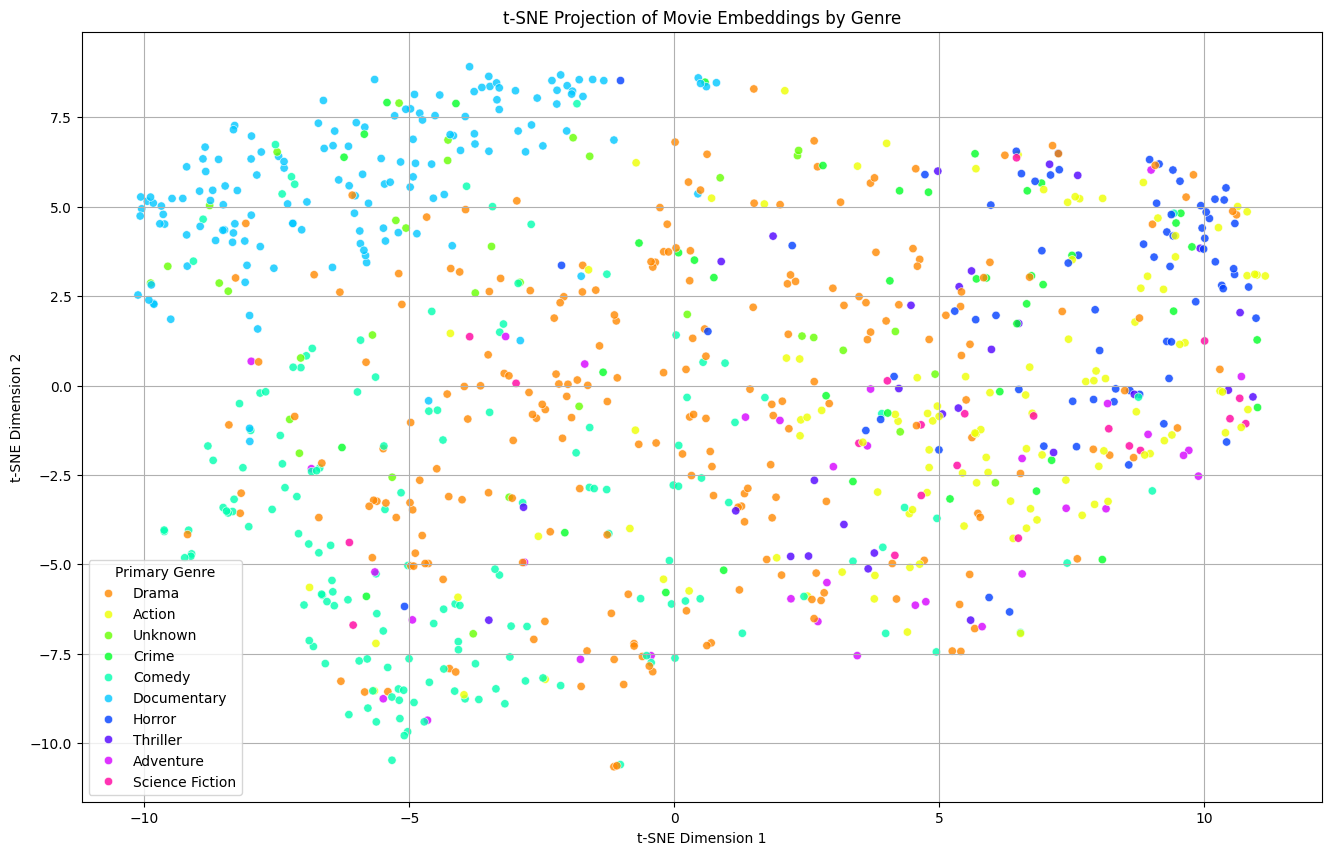


--- How to Interpret the t-SNE Plot ---
Look for distinct color clusters. If dots of the same color (genre) are grouped together,
it means your embeddings have successfully learned the semantic relationship between movies based on their genre.


In [ ]:
# --- 1. Setup and Load Data ---
print("✅ 1. Loading Embeddings...")

# --- IMPORTANT: Update this path to your file ---
EMBEDDINGS_PATH = '/content/drive/MyDrive/Embedding_Based_Recommendations_Project/Datasets/final_datasets/movie_content_embeddings_multitask.parquet'

try:
    df = pd.read_parquet(EMBEDDINGS_PATH)
except FileNotFoundError:
    raise FileNotFoundError(f"ERROR: File not found at {EMBEDDINGS_PATH}. Please verify the path.")

# Convert the 'content_embedding' column from a list of lists/arrays into a proper NumPy matrix
embeddings = np.array(df['content_embedding'].tolist())
print(f"Embeddings loaded successfully. Shape: {embeddings.shape}")

# ---

# --- 2. Perform Sanity Checks ---
print("\n✅ 2. Performing Sanity Checks...")

# Check for NaN or infinity values
if np.isnan(embeddings).any() or np.isinf(embeddings).any():
    print("❌ WARNING: Embeddings contain NaN or infinity values! This may indicate a problem in training.")
else:
    print("✔️ No NaN or infinity values found.")

# Check basic stats
print(f"✔️ Stats: Mean={np.mean(embeddings):.4f}, Std={np.std(embeddings):.4f}, Min={np.min(embeddings):.4f}, Max={np.max(embeddings):.4f}")

# ---

# --- 3. Nearest Neighbors Analysis ---
print("\n✅ 3. Analyzing Nearest Neighbors...")

def find_similar_movies(movie_title: str, top_n: int = 10):
    """
    Finds and prints the most similar movies to a given title based on cosine similarity.
    """
    if movie_title not in df['title'].values:
        print(f"❌ ERROR: Movie '{movie_title}' not found in the dataset.")
        return

    # Find the index and embedding of the anchor movie
    anchor_idx = df[df['title'] == movie_title].index[0]
    anchor_embedding = embeddings[anchor_idx].reshape(1, -1)
    anchor_genre = df.loc[anchor_idx, 'primary_genre']

    # Calculate cosine similarity between the anchor and all other movies
    sim_scores = cosine_similarity(anchor_embedding, embeddings)[0]

    # Get the indices of the most similar movies
    # We sort and take top_n+1 because the most similar movie will be itself
    similar_indices = np.argsort(sim_scores)[::-1][1:top_n+1]

    print(f"\n--- Finding movies similar to: '{movie_title}' (Genre: {anchor_genre}) ---")
    for idx in similar_indices:
        title = df.loc[idx, 'title']
        genre = df.loc[idx, 'primary_genre']
        score = sim_scores[idx]
        print(f"  - Title: {title:<40} | Genre: {genre:<15} | Similarity: {score:.4f}")

# --- Run some examples ---
find_similar_movies("The Dark Knight")
#find_similar_movies("Toy Story")
#find_similar_movies("The Conjuring")


# --- 4. 2D Visualization with t-SNE ---
print("\n✅ 4. Visualizing Embedding Space with t-SNE...")

# For performance, t-SNE is best run on a smaller subset of data.
# Let's take a random sample of 1000 movies.
sample_size = min(1000, len(df))
print(f"Running t-SNE on a sample of {sample_size} movies.")

# Create a random sample of indices
sample_indices = np.random.choice(df.index, sample_size, replace=False)

# Get the corresponding embeddings and genres for the sample
sample_embeddings = embeddings[sample_indices, :]
sample_genres = df.loc[sample_indices, 'primary_genre']

# Perform t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(sample_embeddings)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame({
    'tsne-2d-one': tsne_results[:,0],
    'tsne-2d-two': tsne_results[:,1],
    'genre': sample_genres
})

# Get the top N genres for cleaner plotting
top_genres = tsne_df['genre'].value_counts().nlargest(10).index

# Filter the DataFrame to only include top genres
tsne_df_filtered = tsne_df[tsne_df['genre'].isin(top_genres)]

# Plot the results
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="genre",
    palette=sns.color_palette("hsv", 10),
    data=tsne_df_filtered,
    legend="full",
    alpha=0.8
)
plt.title('t-SNE Projection of Movie Embeddings by Genre')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Primary Genre')
plt.grid(True)
plt.show()

# I went with Model 2, as loss function I used is better and I got better overall loss

# 3D Visualization of Embeddings

In [ ]:
from sklearn.decomposition import PCA
import plotly.express as px
import os

# --- 1. Load the Final Movie Embeddings ---
print("✅ 1. Loading movie embeddings...")

DRIVE_BASE_PATH = '/content/drive/MyDrive/Embedding_Based_Recommendations_Project/Datasets/final_datasets/'
MOVIE_EMBEDDINGS_PATH = os.path.join(DRIVE_BASE_PATH, 'movie_content_embeddings_multitask.parquet')

movies_df = pd.read_parquet(MOVIE_EMBEDDINGS_PATH)

# Prepare the high-dimensional embedding data
high_dim_embeddings = np.array(movies_df['content_embedding'].tolist())
print(f"Loaded {high_dim_embeddings.shape[0]} embeddings of dimension {high_dim_embeddings.shape[1]}")


# --- 2. Reduce Dimensions from 512D to 3D using PCA ---
print("\n✅ 2. Performing dimensionality reduction with PCA...")

pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(high_dim_embeddings)

print("Dimensionality reduction complete.")


# --- 3. Create a DataFrame for Plotting ---
# This combines the 3D coordinates with movie info for plotting
plot_df = pd.DataFrame({
    'x': embeddings_3d[:, 0],
    'y': embeddings_3d[:, 1],
    'z': embeddings_3d[:, 2],
    'title': movies_df['title'],
    'genre': movies_df['primary_genre'] # Use the genre for color-coding
})


# --- 4. Generate the 3D Interactive Plot ---
print("\n✅ 4. Creating the interactive 3D plot...")

fig = px.scatter_3d(
    plot_df,
    x='x',
    y='y',
    z='z',
    color='genre',          # Color each point by its primary genre
    hover_name='title',     # Show the movie title when you hover over a point
    title="3D Interactive Projection of Movie Embeddings"
)

# Improve the layout for better viewing
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=40), # Reduce margins
    legend_title_text='Primary Genre'
)

# Make the markers smaller for a cleaner look
fig.update_traces(marker=dict(size=3))

fig.show()

✅ 1. Loading movie embeddings...
Loaded 1983 embeddings of dimension 512

✅ 2. Performing dimensionality reduction with PCA...
Dimensionality reduction complete.

✅ 4. Creating the interactive 3D plot...


----------